In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib, matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.2.0


GPUs we have available:


In [ ]:
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

grep: /proc/driver/nvidia/gpus/*/information: No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Ontology Embeddings


In [ ]:
from sklearn.metrics.pairwise import cosine_distances

def load_gene_embeddings(name = "dl2vec_vectors", reference_gene = "ESR1"):
  path = "/content/drive/My Drive/MPhil/Ontology Embeddings/"+name+"_vectors.csv"
  embedding_data = pd.read_csv(path)
  labels = embedding_data.pop('Gene_ID')
  print(embedding_data.shape)

  df = pd.read_csv(path)
  # if 'el' not in path:
  df = df.set_index('Gene_ID')

  reference_emb = df.loc[reference_gene].to_numpy().reshape(1, -1)
  cos_distances = {}

  for index, row in df.iterrows():
      similarity = cosine_distances(reference_emb, row.to_numpy().reshape(1, -1))
      cos_distances[index] = similarity

  cos_distances_sorted = {k: v for k, v in sorted(cos_distances.items(), key=lambda item: item[1])}
  return cos_distances_sorted

In [ ]:
# cancer_drivers = ['FOXA1', 'BRCA2', 'TP53', 'PIK3CA', 'GATA3', 'ERBB2', 'WWP1', 'RARA']

# for g in cancer_drivers:
#   print("{} with position {} and cos distance {:1.3f}".format(g, list(cos_distances_sorted.keys()).index(g), cos_distances_sorted[g][0][0]))

# Dataset

In [ ]:
def discretize(df, bins=200):
    print(f"Discretizing features into {bins} bins")
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = pd.cut(df[feature_name], bins=bins, labels=range(bins), include_lowest=True)
        # result[feature_name], _ = pd.factorize(cut_result)
    return result


def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value != min_value:
          result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def load_data(task = 'PAM50', subset='all', discrete=False, bins=200):
    if subset == 'all':
        path = "/content/drive/My Drive/MPhil/Data/MBdata_all.csv"
    elif subset == 'original':
        path = "/content/drive/My Drive/MPhil/Data/MBdata_original.csv"
    df = pd.read_csv(path)
    if task == 'DR':
        df = df[df.DR != '?']
        target = df.pop('DR')
    elif task == 'ER':
        df = df[df.ER_Status != '?']
        target = df.pop('ER_Status')
        labels = {
            'pos': 0,
            'neg': 1
        }
        target = target.apply(lambda x: labels[x])
    elif task == 'iC10':
        df = df[df.iC10 != '?']
        target = df.pop('iC10')
        labels = {
            '4ER-': 4,
            '4ER+': 0
        }
        target = target.apply(lambda x: labels[x] if x in labels else int(x))
    elif task == 'PAM50':
        df = df[df.Pam50Subtype != '?']
        target = df.pop('Pam50Subtype')
        pam50_lables = {
            'Normal': 0,
            'LumA': 1,
            'LumB': 2,
            'Basal': 3,
            'Her2': 4
        }
        target = target.apply(lambda x: pam50_lables[x])


    features = df.filter(regex='^GE.*')
    features = features.astype('float64')
    # print(features.shape)

    if discrete:
        features = discretize(features, bins)
    else:
        features = normalize(features)
        features.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return features, target

## Experiments

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, train_test_split
import random


In [ ]:
# Setup the results dictionary
import pickle

res_csv_file = "/content/drive/My Drive/MPhil/results/fs_results.csv"
try:
    # results = pickle.load(open(res_file, "rb"), encoding='latin1')
    results = pd.read_csv(res_csv_file)
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['task', 'acc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed', 'with_ref', 'embeddings'])
    print("Created a New Results Dictionary")
    with open(res_csv_file, 'w+') as f:
        f.write(results.to_csv(sep=',', header=True, index=False))

Loaded Checkpointed Results


In [ ]:
results


In [ ]:
def run_experiments(features, target, task, with_ref = True, embeddings = 'dl2vec', reference_gene='ESR1'):
  results = pd.read_csv(res_csv_file)

  # features = features.filter(regex='^GE.*').copy()
  # features = normalize(features)
  # features.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
  print(features.shape)
  columns = list(features.columns)
  features_org = features.copy()
  
  top_genes = None
  if embeddings != "random" and embeddings != 'curtis':
    cos_distances_sorted = load_gene_embeddings(name=embeddings, reference_gene=reference_gene)
    top_genes = ['GE_'+g for g,v in cos_distances_sorted.items() if 'GE_'+g in list(features.columns)]
    print(top_genes[:10])

  for n in [24368, 10000,1000,100,10,5,2,1]:
    # for _ in range(5):24368, 10000,1000,100,10,5,2,1
    # if n != 24368:
    if embeddings == "random":
      random.shuffle(columns)
      features = features_org.copy()
      if with_ref:
        features = features.filter(columns[:n-1] + ['GE_ESR1'])
      else:
        features = features.filter(columns[:n])
    elif top_genes is not None:
      if with_ref:
        features = features.filter(top_genes[:n])
      else:
        features = features.filter(top_genes[1:n+1])
    features_size = len(list(features.columns))

    names = list(features.columns)
    rf = RandomForestClassifier()
    kf = KFold(n_splits=5)
    feature_imp = []
    acc = []
    acc_test = []
    pred = []
    ref = []

    x_train = features.values[:]
    y_train = target.values[:]

    for train, valid in kf.split(x_train, y_train):
      rf.fit(x_train[train], y_train[train])
      feature_imp.append(rf.feature_importances_.copy())
      y_pred=rf.predict(x_train[valid])
      acc.append(metrics.accuracy_score(y_train[valid], y_pred))
      pred += list(y_pred)
      ref += list(y_train[valid])
      results = results.append({'task':task, 'acc': acc[-1], 'gene': reference_gene, 'num_genes': features_size, 'with_ref': with_ref, 'model':"RF", 'embeddings':embeddings}, ignore_index=True)
    acc = np.mean(acc)


    print(f"Accuracy:{acc:.3}, Feature set size:{features_size}")

  with open(res_csv_file, 'w') as f:
    f.write(results.to_csv(sep=',', header=True, index=False))

In [ ]:
for task in ['iC10', 'ER', 'PAM50', 'DR']:
  features, target = load_data(task=task, subset='all', discrete=False)
  # run_experiments(features, target, with_ref = False, embeddings = "random", task=task)
  run_experiments(features, target, with_ref = True, embeddings = "opa2vec_go", task=task)
  run_experiments(features, target, with_ref = True, embeddings = "el", task=task)
  # run_experiments(features, target, with_ref = True, embeddings = "opa2vec", task=task)

In [ ]:
run_experiments(features, target, with_ref = False, embeddings = "random")

In [ ]:
run_experiments(features, target, with_ref = True, embeddings = "opa2vec_go")
run_experiments(features, target, with_ref = True, embeddings = "el")

# run_experiments(features, target, with_ref = True, embeddings = "opa2vec")

In [ ]:
run_experiments(features, target, with_ref = True, embeddings = "el")
run_experiments(features, target, with_ref = True, embeddings = "dl2vec")

In [ ]:
for task in ['DR']: #['ER', 'DR', 'PAM50', 'iC10']:
  features, target = load_data(task=task, subset='original', discrete=False)
  run_experiments(features, target, with_ref = True, embeddings = "curtis", task=task)

## Plot

In [ ]:
# Setup the results dictionary
import pickle

res_csv_file = "/content/drive/My Drive/MPhil/results/fs_results.csv"
results = pd.read_csv(res_csv_file)
print("Loaded Checkpointed Results")
results


In [ ]:
subset = results[(results.num_genes>= 10)& (results.with_ref==False)]
q = subset.groupby(['embeddings','num_genes'])['acc']
todo = list(subset["embeddings"].unique())
for ls, model in enumerate(sorted(todo)):
    index = list(q.mean()[model].index)
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    for i,m,s in zip(index, mean, stderr):
      print(f"{i} {m:.3f} +- {s:.3f}")

10 0.609 +- 0.036
100 0.726 +- 0.028
1000 0.764 +- 0.023
10000 0.785 +- 0.022
24368 0.757 +- 0.022


In [ ]:
results['gene'] = results['gene'].replace(np.nan, 'ESR1')


In [ ]:
with open(res_csv_file, 'w') as f:
  f.write(results.to_csv(sep=',', header=True, index=False))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


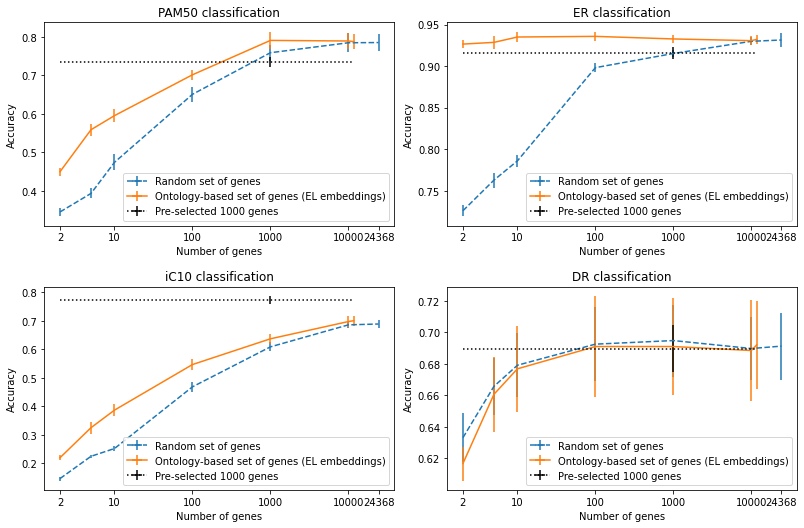

In [ ]:
import itertools

%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 8.6)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.3)

tasks = [ "PAM50", "ER", "iC10", "DR"] #, "RPL13"] #, "IL5"]
for i, task in enumerate(tasks):
    j = int(i/2)
    k = i%2

    subset = results[(results.num_genes>= 2) & (results.task==task)] # & (results.with_ref==True)]
    q = subset.groupby(['embeddings','gene','num_genes' ])['acc']
    print(q)
    todo = [x for x in itertools.product( list(subset["embeddings"].unique()),list(subset["gene"].unique()))]
    linestyles = ['-', '-', '-', '-.', ':']
    for ls, (model, gene) in enumerate(todo):
      if model in ['random', 'el'] and (task != 'iC100' or gene == 'ERBB2' or model == 'random'):
        try:          
          index = list(q.mean()[model, gene].index)
          mean = q.mean()[model, gene]
          stderr = q.std()[model, gene]/np.sqrt(q.count()[model, gene])
          displayname = "Random set of genes" if model=='random' else "Ontology-based set of genes (EL embeddings)"
          axs[j][k].errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='--' if model=='random' else '-')
        except:
          pass

    baseline = results.loc[(results.embeddings == 'curtis')& (results.task==task)]
    axs[j][k].errorbar(index, 
                 [baseline.mean()['acc']]*len(index),label="Pre-selected 1000 genes", 
                 xerr=0, 
                 yerr=[baseline.std()['acc']/np.sqrt(baseline.count()['acc']) if n==1000 else 0 for n in index], 
                 ls=':', color="black")

    axs[j][k].set_title(task + " classification")
    axs[j][k].set_ylabel("Accuracy")
    axs[j][k].set_xlabel("Number of genes")
    axs[j][k].set_xscale("symlog")
    axs[j][k].set_xticks([2,10,100,1000,10000,24368]) #sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axs[j][k].xaxis.set_major_formatter(formatter)
    axs[j][k].legend(loc='lower right');


plt.savefig("/content/drive/My Drive/MPhil/results/graphs/fs_el.eps", bbox_inches='tight', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


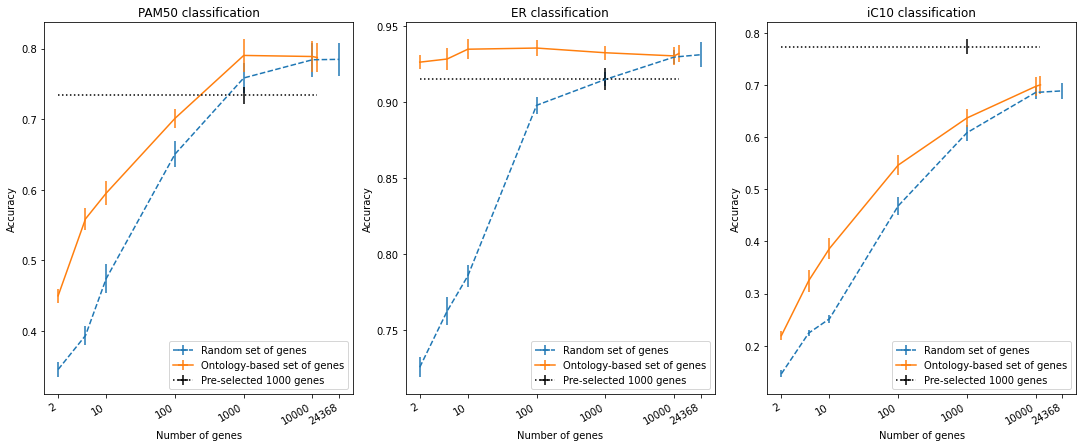

In [ ]:
import itertools

%matplotlib inline
plt.rcParams['figure.figsize'] = (18.5, 7.6)
fig, axs = plt.subplots(1,3, sharex=False, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.17, hspace=0.3)

tasks = [ "PAM50", "ER", "iC10"] #, "RPL13"] #, "IL5"]
for i, task in enumerate(tasks):

    subset = results[(results.num_genes>= 2) & (results.task==task)] # & (results.with_ref==True)]
    q = subset.groupby(['embeddings','gene','num_genes' ])['acc']
    print(q)
    todo = [x for x in itertools.product( list(subset["embeddings"].unique()),list(subset["gene"].unique()))]
    linestyles = ['-', '-', '-', '-.', ':']
    for ls, (model, gene) in enumerate(todo):
      if model in ['random', 'el'] and (task != 'iC100' or gene == 'ERBB2' or model == 'random'):
        try:          
          index = list(q.mean()[model, gene].index)
          mean = q.mean()[model, gene]
          stderr = q.std()[model, gene]/np.sqrt(q.count()[model, gene])
          displayname = "Random set of genes" if model=='random' else "Ontology-based set of genes"
          axs[i].errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='--' if model=='random' else '-')
        except:
          pass

    baseline = results.loc[(results.embeddings == 'curtis')& (results.task==task)]
    axs[i].errorbar(index, 
                 [baseline.mean()['acc']]*len(index),label="Pre-selected 1000 genes", 
                 xerr=0, 
                 yerr=[baseline.std()['acc']/np.sqrt(baseline.count()['acc']) if n==1000 else 0 for n in index], 
                 ls=':', color="black")

    axs[i].set_title(task + " classification")
    axs[i].set_title(task + " classification")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_xlabel("Number of genes")
    axs[i].set_xscale("symlog")
    axs[i].set_xticks([2,10,100,1000,10000,24368]) #sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axs[i].xaxis.set_major_formatter(formatter)
    axs[i].legend(loc='lower right');
    # axs[i].get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    fig.autofmt_xdate()



plt.savefig("/content/drive/My Drive/MPhil/results/graphs/fs_el.eps", bbox_inches='tight', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


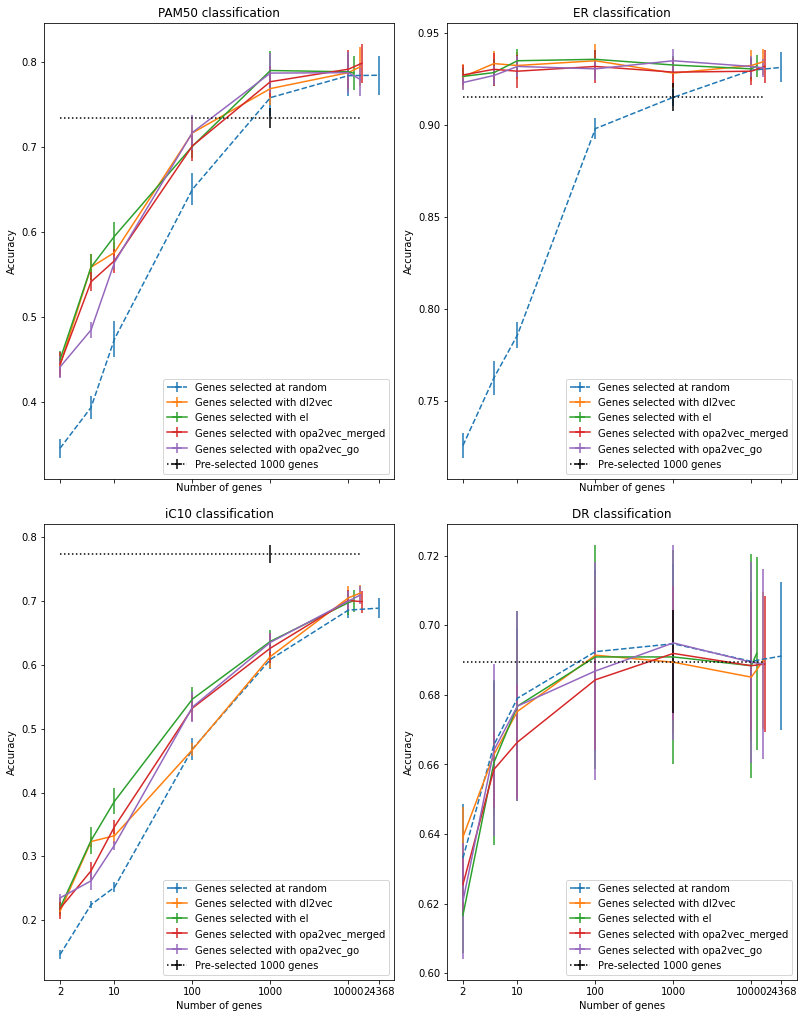

In [ ]:
import itertools

%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 17.6)
fig, axs = plt.subplots(2,2, sharex=True, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.1)

tasks = [ "PAM50", "ER", "iC10", "DR"] #, "RPL13"] #, "IL5"]
for i, task in enumerate(tasks):
    j = int(i/2)
    k = i%2

    subset = results[(results.num_genes>= 2) & (results.task==task)] # & (results.with_ref==True)]
    q = subset.groupby(['embeddings','gene','num_genes' ])['acc']
    print(q)
    todo = [x for x in itertools.product( list(['random', 'dl2vec', 'el', 'opa2vec', 'opa2vec_go']),list(['ESR1']))]
    linestyles = ['-', '-', '-', '-.', ':']
    for ls, (model, gene) in enumerate(todo):
      if model in ['random', 'dl2vec', 'el', 'opa2vec', 'opa2vec_go'] and (task != 'iC100' or gene == 'ERBB2' or model == 'random'):
        try:          
          index = list(q.mean()[model, gene].index)
          mean = q.mean()[model, gene]
          stderr = q.std()[model, gene]/np.sqrt(q.count()[model, gene])
          displayname = 'opa2vec_merged' if model=='opa2vec' else model #"Random set of genes" if model=='random' else "Ontology-based set of genes"
          displayname = "Genes selected at random" if displayname == 'random' else "Genes selected with "+displayname
          
          axs[j][k].errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='--' if model=='random' else '-')
        except:
          pass

    baseline = results.loc[(results.embeddings == 'curtis')& (results.task==task)]
    axs[j][k].errorbar(index, 
                 [baseline.mean()['acc']]*len(index),label="Pre-selected 1000 genes", 
                 xerr=0, 
                 yerr=[baseline.std()['acc']/np.sqrt(baseline.count()['acc']) if n==1000 else 0 for n in index], 
                 ls=':', color="black")

    axs[j][k].set_title(task + " classification")
    axs[j][k].set_ylabel("Accuracy")
    axs[j][k].set_xlabel("Number of genes")
    axs[j][k].set_xscale("symlog")
    axs[j][k].set_xticks([2,10,100,1000,10000,24368]) #sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axs[j][k].xaxis.set_major_formatter(formatter)
    axs[j][k].legend(loc='lower right');


plt.savefig("/content/drive/My Drive/MPhil/results/graphs/fs_all2.eps", bbox_inches='tight', format='eps')
plt.show()

curtis num_genes
1000    0.773737
Name: acc, dtype: float64
dl2vec num_genes
10       0.368434
100      0.502020
1000     0.633333
10000    0.705808
14308    0.708081
Name: acc, dtype: float64
el num_genes
10       0.386364
100      0.546465
1000     0.636869
10000    0.697475
11730    0.700505
Name: acc, dtype: float64
opa2vec num_genes
10       0.346465
100      0.532323
1000     0.626263
10000    0.701010
14964    0.698990
Name: acc, dtype: float64
opa2vec_go num_genes
10       0.317677
100      0.533838
1000     0.635354
10000    0.700000
14291    0.709596
Name: acc, dtype: float64


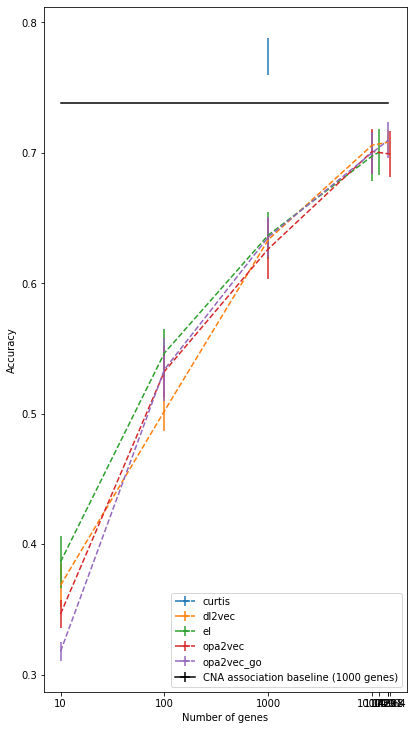

In [ ]:
emb_names = {
        "opa2vec_go_vectors": "opa2vec-go",
        "opa2vec_vectors_all": "opa2vec-merged",
        "el_vectors_all2": "el"
    }

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.5, 12.6)

subset = results[(results.num_genes>= 10) & (results.with_ref==True) & (results.task=='iC10')]
q = subset.groupby(['embeddings','num_genes'])['acc']
print(q)
todo = list(subset["embeddings"].unique())
linestyles = ['-', '-', '-', '-.', ':']
for ls, model in enumerate(sorted(todo)):
    index = list(q.mean()[model].index)
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    if model in emb_names:
      displayname = emb_names[model]
    else:
      displayname = model

    print(model, mean)
    plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='--')

plt.errorbar(index, [0.738]*len(index),label="CNA association baseline (1000 genes)", xerr=0, yerr=0, ls='-', color="black")

# plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
plt.ylabel("Accuracy")
plt.xlabel("Number of genes")
plt.xscale("symlog")
plt.xticks(sorted(subset["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend();
# fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
# print(fd)
# if fd > 50:
#     plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
#     c = plt.ylim()
#     plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


plt.savefig("/content/drive/My Drive/MPhil/results/graphs/PAM50_withoutESR1.png", bbox_inches='tight')
plt.show()

In [ ]:
pickle.dump(results, open(res_file, 'wb'))

## Confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=[f[0] for f in top_features], y=[f[1] for f in top_features])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()

In [ ]:
 '|'.join([ e[1] for i, e in enumerate(top_features) ])

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(top_features_test, top_features_pred)
print(matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_labels=pam50_lables.keys()

figure = plt.figure(figsize=(2, 2))
sns.heatmap(matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=plot_labels , yticklabels=plot_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()